In [1]:
!which python

/home/ubuntu/miniconda3/envs/cinference/bin/python


# Introduction

Adeano-associated viruses (AAVs) are used in gene therapy as genome vehicle. They are found in different tissues on different animals as well as humans. These are call wild type ones. 

In order to increase the efficiency of gene therapy, we need good AAV capsdid, ie, their covers. The goodness are measured according to the following criteria

1. tissue tropism: whether they can attach to a specific organs such as lunch, heart, or liver
2. thermal stability: whether the AAV capsid are stable under heat
3. immunological reaction: whether the AAV capsid invoke the reaction of the host immune system.

Directed evolution approach in protein engineering are costly and slow, we want to accelerate it by using ML-methods to recommend potential candidates for wet-lab experiments.

Our vision is to build an end-to-end platform to design protein sequence → start with AAV capsid

At the moment we have experimented with: 

- We are building a testbed to experiment with different protein engineering methods in silico. They include three main part
    - Oracles: predictive models that can be trained on real dataset
    - Ground Truth: These are landscapes of (x,y), where x and y are sequence and fitness score, respectively. These are collected using wet-lab experiments.  They are used to benchmark different recommenders
    - Recommenders: These algorithms use oracles to navigate the ground truth landscape. Note that we do not have access to the landscape in a real experiment.
- AAV tropism dataset from "Comprehensive AAV capsid fitness landscape reveals a viral gene and enables machine-guided design" by Ogden, Pierce J and Kelsic, Eric D and Sinai, Sam and Church, George M.
- We try different methods
    - CbAS, DbAS.: the main idea cast the exploration problem as an optimization problem, where you wan to maximize the expectation of the likelihood a given sequence has desired properties. The expectation is computed with respect to the generative distribution.


The production of AAVs capsid are controled by the **cap** section on the virus genome. 


### DbAS

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
import numpy as np
import json

In [3]:
import sys
sys.path.insert(0, '../')

import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

### Additive AAV tropism capsid

Let's build a landscape (ground truth) for liver

In [4]:
import pprint

In [5]:
additive_aav_problem = flexs.landscapes.additive_aav_packaging.registry()['liver']
additive_aav_landscape = flexs.landscapes.AdditiveAAVPackaging(**additive_aav_problem['params'])
additive_aav_wt = additive_aav_landscape.wild_type
additive_aav_landscape = flexs.landscapes.AdditiveAAVPackaging(**additive_aav_problem['params'])

pprint.pprint(additive_aav_problem)
print(f'WT: {additive_aav_wt}, fitness: {additive_aav_landscape.get_fitness([additive_aav_wt])}')

{'params': {'end': 540, 'phenotype': 'liver', 'start': 450}}
WT: PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVL, fitness: [0.5]


Let's explore the landscape. We need three ingredients

1. Oracle
2. Generative model
3. Explorer

we start from the wild type

In [6]:
starting_sequence = additive_aav_wt

alphabet = s_utils.AAS

cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

vae = baselines.explorers.VAE(len(starting_sequence), alphabet=alphabet, epochs=10, verbose=False)

cbas_explorer = baselines.explorers.CbAS(
    model=cnn,
    generator=vae,
    cycle_batch_size=100,
    rounds=3,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=2000,
    alphabet=alphabet,
)

In [7]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
cbas_sequences, metadata = cbas_explorer.run(landscape=additive_aav_landscape)

round: 0, top: 0.5, time: 0.000511s


/home/ubuntu/miniconda3/envs/cinference/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.5042647600973422, time: 2.021807s


/home/ubuntu/miniconda3/envs/cinference/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


0 100
100 100
200 100
300 100
400 100
500 100
600 100
700 100
800 100
900 100
1000 100
1100 100
1200 100
1300 100
1400 100
1500 100
1600 100
1700 100
1800 100


../flexs/baselines/explorers/cbas_dbas.py:175: RuntimeWarning: overflow encountered in exp
  weights = np.exp(log_probs_0 - log_probs_t)


1900 100
round: 2, top: 0.5042647600973422, time: 242.314949s


/home/ubuntu/miniconda3/envs/cinference/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


0 100
100 100
200 100
300 100
400 100
500 100
600 100
700 100
800 100
900 100
1000 100
1100 100
1200 100
1300 100
1400 100
1500 100
1600 100
1700 100
1800 100
1900 100
round: 3, top: 0.5042647600973422, time: 238.656502s


In [10]:
metadata

{'run_id': '15:15:35-11/12/2020',
 'exp_name': 'cbas_Q=0.7_generator=VAE_latent_dim=2_intermediate_dim=250',
 'model_name': 'CNN_hidden_size_100_num_filters_32',
 'landscape_name': 'AdditiveAAVPackaging_phenotype=liver',
 'rounds': 3,
 'sequences_batch_size': 100,
 'model_queries_per_batch': 2000}

In [11]:
cbas_sequences

,sequence,model_score,true_score,round,model_cost,measurement_cost
0,PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNN...,NaN,0.500000,0,0,1
0,PSGTTTQSRLQFSQAGASDIRDQSRNWLPNPCYRQQRVSKTSADNN...,0.403502,0.000000,1,100,101
1,PDGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADGN...,0.397954,0.042403,1,100,101
2,PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSDDNN...,0.386385,0.228401,1,100,101
3,PSGTTTQSRLQFSQAGASDIRDQNRNWLPGPCYRQQRVSKTSADNN...,0.404634,0.348008,1,100,101
...,...,...,...,...,...,...
94,SEWQDPQNVDSNIWEPHKRVMGSDSYQIWMPGVGDCNSIKVGPMIE...,0.022504,0.000000,3,4100,299
95,SIMCLTQYYMHEYKVPYTMLMCNRCRYIRNPCHGHTKVILFSQMKE...,0.022477,0.000000,3,4100,299
96,FAMQTKASPPVNYGVYSDCADICPQRFELHCMVVYHDPSKYVQLKG...,0.022452,0.000000,3,4100,299
97,SIWCLTQMYSHEYKQPCTMLMCNRCRFIRNPVHGHTKVILFSQMKE...,0.022438,0.000000,3,4100,299


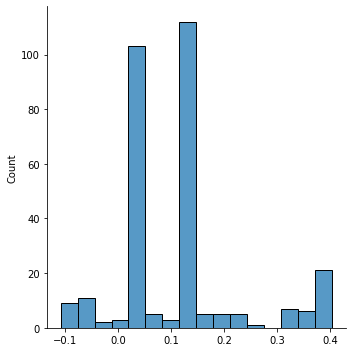

In [12]:
sns.displot(cbas_sequences.model_score - cbas_sequences.true_score)